In [2]:
import torch.nn as nn

In [28]:
!nvidia-smi

Sun May 14 11:29:05 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce 940MX            On | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8               N/A /  N/A|     10MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
class CoordPredict(nn.Module):
    def __init__(self):
        super(CoordPredict, self).__init__()

        self.conv1 = nn.Conv2d(1, 200, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(200)
        self.conv2 = nn.Conv2d(200, 300, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(300)
        self.conv3 = nn.Conv2d(300, 300, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(300)
        self.conv4 = nn.Conv2d(300, 250, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(250)
        self.conv5 = nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(250)
        self.conv6 = nn.Conv2d(250, 200, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(200)
        
        self.fc = nn.Linear(200*2*2, 4)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, 200*2*2)
        x = F.sigmoid(self.fc(x))
        #x = x.view(-1, 1, 150, 150)
        return x


In [4]:
import pandas as pd 
df = pd.read_csv('./DataFrame/ImgCoords.csv')
#list(df['COORDS'][3])

In [19]:
import pickle

with open('boxCoord.pkl', 'rb') as file:
    file = pickle.load(file)

In [20]:
len(file)

5180

In [24]:
import os

In [25]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np

class MyDataset(Dataset):
    def __init__(self, image_dir, coord_list, transform=None):
        self.image_dir = image_dir
        #self.mask_dir = mask_dir
        self.train_dirs = os.listdir(image_dir)
        self.coord_list = coord_list
        self.transform = transform

    def __len__(self):
        return 5180
        
    def __getitem__(self, idx):
        # load image and convert to RGB
        name = self.train_dirs[idx]
        img_path = os.path.join(self.image_dir, name)
        image = Image.open(img_path).convert('L')
        
        coordlist = self.coord_list[idx]

        #transform = transforms.Compose([transforms.PILToTensor()])
        transform = transforms.Compose([transforms.Resize((150,150)), transforms.ToTensor()])

        #transforming
        image = transform(image)
        image = torch.tensor(image)
        
        sample = {'image': image,  'coords':coordlist}
        return sample

# Example usage
#image_dir = "./memotion_dataset_7k/images"
image_dir = r'./BLACK_AND_WHITE/'

#mask_dir = r'./CAMO-V.1.0/GT/'

dataset = MyDataset(image_dir,file,transform=None)
dataloader = DataLoader(dataset,batch_size=1,shuffle=True)


In [26]:
import torch
from PIL import Image
import torchvision.transforms as transforms

In [29]:
import torch.optim as optim
import gc

model = CoordPredict()
model = model.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 50

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        #try:
        image = data['image'].to('cuda')
        #print("No.",i," batch of 5 images being processed...s")

        optimizer.zero_grad()
        coord = data['coords'].to('cuda')
        # Forward pass
        output = model(image)
        
        l1 = torch.squeeze(output,dim=0)
        l2 = torch.squeeze(coord,dim=0)
        
        l1 = torch.tensor(l1,dtype=float).requires_grad_(True)
        l2 = torch.tensor(l2,dtype=float).requires_grad_(True)
        
        loss = criterion(l1, l2)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

        if i % 10 == 0:    # Print every 10 mini-batches
            print('[Epoch: %d, Batch: %d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10000))
            running_loss = 0.0
#         except (ValueError, TypeError):
#             # code to handle the error
#             print("Error: invalid value or type")

/tmp/ipykernel_4209/2754688005.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)
/tmp/ipykernel_4209/4048210158.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l1 = torch.tensor(l1,dtype=float).requires_grad_(True)
/tmp/ipykernel_4209/4048210158.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l2 = torch.tensor(l2,dtype=float).requires_grad_(True)


[Epoch: 1, Batch: 1] Loss: 0.000
[Epoch: 1, Batch: 11] Loss: 0.857
[Epoch: 1, Batch: 21] Loss: 0.785
[Epoch: 1, Batch: 31] Loss: 1.631
[Epoch: 1, Batch: 41] Loss: 1.199
[Epoch: 1, Batch: 51] Loss: 1.482
[Epoch: 1, Batch: 61] Loss: 0.647
[Epoch: 1, Batch: 71] Loss: 1.230
[Epoch: 1, Batch: 81] Loss: 1.361
[Epoch: 1, Batch: 91] Loss: 1.466
[Epoch: 1, Batch: 101] Loss: 1.293
[Epoch: 1, Batch: 111] Loss: 1.517
[Epoch: 1, Batch: 121] Loss: 1.269
[Epoch: 1, Batch: 131] Loss: 1.146
[Epoch: 1, Batch: 141] Loss: 1.088
[Epoch: 1, Batch: 151] Loss: 0.978
[Epoch: 1, Batch: 161] Loss: 0.879
[Epoch: 1, Batch: 171] Loss: 1.262
[Epoch: 1, Batch: 181] Loss: 1.150
[Epoch: 1, Batch: 191] Loss: 1.821
[Epoch: 1, Batch: 201] Loss: 1.105
[Epoch: 1, Batch: 211] Loss: 1.203
[Epoch: 1, Batch: 221] Loss: 1.306
[Epoch: 1, Batch: 231] Loss: 0.745
[Epoch: 1, Batch: 241] Loss: 1.306
[Epoch: 1, Batch: 251] Loss: 0.651
[Epoch: 1, Batch: 261] Loss: 0.934
[Epoch: 1, Batch: 271] Loss: 1.283
[Epoch: 1, Batch: 281] Loss: 1.

[Epoch: 1, Batch: 2311] Loss: 1.447
[Epoch: 1, Batch: 2321] Loss: 1.433
[Epoch: 1, Batch: 2331] Loss: 0.938
[Epoch: 1, Batch: 2341] Loss: 1.571
[Epoch: 1, Batch: 2351] Loss: 1.103
[Epoch: 1, Batch: 2361] Loss: 0.649
[Epoch: 1, Batch: 2371] Loss: 0.944
[Epoch: 1, Batch: 2381] Loss: 1.008
[Epoch: 1, Batch: 2391] Loss: 1.183
[Epoch: 1, Batch: 2401] Loss: 1.449
[Epoch: 1, Batch: 2411] Loss: 0.851
[Epoch: 1, Batch: 2421] Loss: 0.885
[Epoch: 1, Batch: 2431] Loss: 0.539
[Epoch: 1, Batch: 2441] Loss: 1.534
[Epoch: 1, Batch: 2451] Loss: 0.745
[Epoch: 1, Batch: 2461] Loss: 1.117
[Epoch: 1, Batch: 2471] Loss: 0.601
[Epoch: 1, Batch: 2481] Loss: 1.478
[Epoch: 1, Batch: 2491] Loss: 1.558
[Epoch: 1, Batch: 2501] Loss: 1.076
[Epoch: 1, Batch: 2511] Loss: 0.769
[Epoch: 1, Batch: 2521] Loss: 1.626
[Epoch: 1, Batch: 2531] Loss: 1.037
[Epoch: 1, Batch: 2541] Loss: 1.244
[Epoch: 1, Batch: 2551] Loss: 1.350
[Epoch: 1, Batch: 2561] Loss: 0.832
[Epoch: 1, Batch: 2571] Loss: 1.317
[Epoch: 1, Batch: 2581] Loss

KeyboardInterrupt: 

In [ ]:
torch.squeeze(l1,dim=0),torch.squeeze(l2,dim=0)

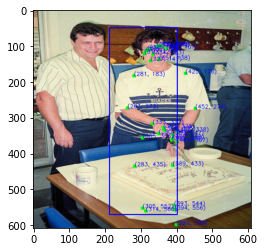

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Load the pose estimation model
mp_pose = mp.solutions.pose

# Read and preprocess the image
image = cv2.imread('./person_images/000000000113.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform pose estimation
with mp_pose.Pose(static_image_mode=True) as pose:
    results = pose.process(image_rgb)
    landmarks = results.pose_landmarks

    # Extract body coordinates and display them
    if landmarks:
        # Create a list to store the coordinates
        coordinates = []

        for i, landmark in enumerate(landmarks.landmark):
            # Get the x, y coordinates of each body part
            height, width, _ = image.shape
            x = int(landmark.x * width)
            y = int(landmark.y * height)

            # Append the coordinates to the list
            coordinates.append((x, y))

            # Display the coordinates on the image
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
            cv2.putText(image, f"({x}, {y})", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

        # Calculate the bounding box coordinates
        x_min = min(x for x, _ in coordinates) -50
        x_max = max(x for x, _ in coordinates) -50 
        y_min = min(y for _, y in coordinates) -50
        y_max = max(y for _, y in coordinates) -50

        # Draw a box around the person
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Display the image with coordinates and the box
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
